In [1]:
import dlc_bci as bci

In [2]:
import torch
from torch import cuda , nn , optim
from torch.optim import lr_scheduler 
from torch.nn import functional as F 
from torch.autograd import Variable 

In [3]:
torch.__version__

'0.3.1.post2'

In [4]:
import numpy as np
from sklearn import svm 

In [5]:
train_input, train_target = bci.load(root='./data_bci')
test_input, test_target = bci.load(root='./data_bci', train=False)
print(str(type(train_input)), train_input.size()) 
print(str(type(train_target)), train_target.size())
print(str(type(test_input)), test_input.size()) 
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


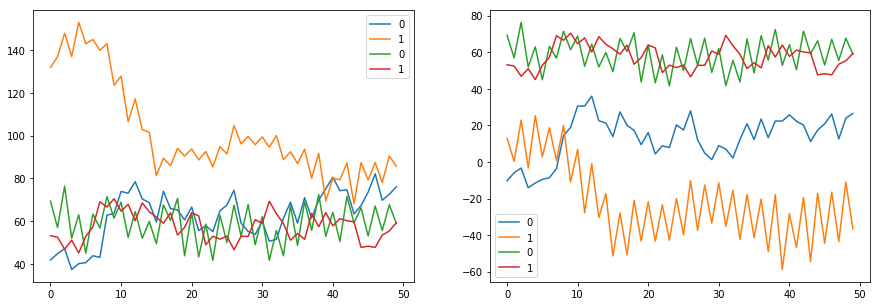

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(range(50),np.array(train_input[0,0]))
ax[0].plot(range(50),np.array(train_input[1,0]))
ax[0].plot(range(50),np.array(train_input[2,0]))
ax[0].plot(range(50),np.array(train_input[3,0]))
ax[0].legend(train_target[:4])
ax[1].plot(range(50),np.array(train_input[0,1]))
ax[1].plot(range(50),np.array(train_input[1,1]))
ax[1].plot(range(50),np.array(train_input[2,0]))
ax[1].plot(range(50),np.array(train_input[3,0]))
ax[1].legend(train_target[:4])

In [7]:
# Randomly choose train and test set #

In [8]:
# Normalization
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
# convert to Variable
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

## Support Vector Machine -- Baseline

In [9]:
X_train = train_input.view(316,-1)
y_train = train_target
X_test = test_input.view(100,-1)
y_test = test_target

In [10]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train.data, y_train.data)
clf.score(X_test.data, y_test.data)

0.75

# Neural Network

In [11]:
train_input = train_input.view(316,28,50)
test_input = test_input.view(100,28,50)

In [1104]:
class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        
        self.conv1 = nn.Conv1d(28, 50, kernel_size=5)
        self.conv1_bn = nn.BatchNorm1d(50)
        self.conv1_drop = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(50, 100, kernel_size=5)
        self.conv2_bn = nn.BatchNorm1d(100)
        self.conv2_drop = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(1400,500)
        self.fc1_bn = nn.BatchNorm1d(500)
        self.fc1_drop = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(500,100)
        self.fc2_bn = nn.BatchNorm1d(100)
        self.fc2_drop = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(100,2)
        
    def forward(self, x): 
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        #x = F.max_pool1d(x, 3)
        x = self.conv1_drop(x)
        
        
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool1d(x, 3)
        x = self.conv2_drop(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc1_drop(x)
        
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc2_drop(x)
        
        x = F.softmax(self.fc3(x), 1)
        return x

In [1105]:
# test the structure
model = Net_1D()
print(model(train_input).shape)

torch.Size([316, 2])


In [1118]:
def train_model(model, train_input, train_target):
    lr, nb_epochs = 1e-3, 150
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2) # lr=1e-1
    #optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=1e-3) # lr=1e-1
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1) # lr=1e-3

    scheduler = lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.5)
    
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
    for k in range(nb_epochs):
        scheduler.step()
        
        optimizer.zero_grad()
        output = model(train_input) 
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if k%10==0 : print(k, error, loss.data[0])
        errors.append(error)
        losses.append(loss.data[0])
    return errors, losses

In [1119]:
def compute_nb_errors(model, data_input, data_target):
    nb_errors = 0
    output = model.forward(data_input)
    pred = output.data.max(1, keepdim=True)[1]
    nb_errors = pred.ne(data_target.data.view_as(pred)).sum()
    return nb_errors

0 140 0.6921642422676086
10 125 0.6739139556884766
20 108 0.6685339212417603
30 96 0.637703537940979
40 71 0.5972914695739746
50 48 0.5678697228431702
60 40 0.55539870262146
70 37 0.533309280872345
80 22 0.5191576480865479
90 22 0.507315456867218
100 19 0.5141214728355408
110 19 0.5084826946258545
120 11 0.49937915802001953
130 14 0.4993707239627838
140 16 0.5051001906394958


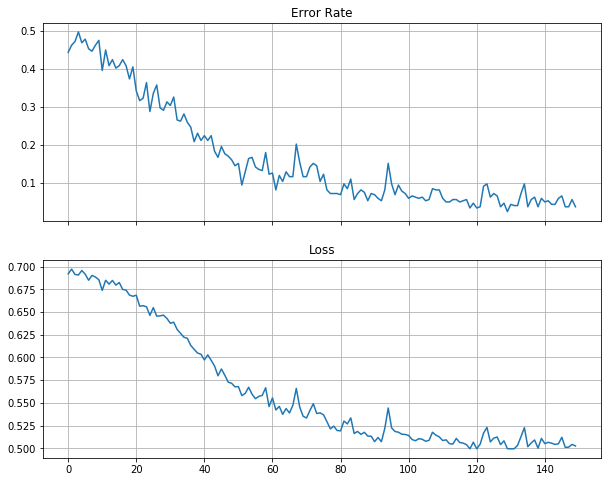

Correct: 77.00%


In [1120]:
model = Net_1D()

errors, losses = train_model(model, train_input, train_target)

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

nb_error = compute_nb_errors(model, test_input, test_target)
print('Correct: {:.2%}'.format(1-nb_error/test_input.size(0)))

In [1324]:
train_input = train_input.view(316,50,28)
test_input = test_input.view(100,50,28)

In [1325]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=28,
            hidden_size=10,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout=0.5,
        )
        self.bn  = nn.BatchNorm2d(10)
        self.out = nn.Linear(10, 2)
        
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = F.softmax(self.out(self.bn(r_out[:, -1, :])), 1)
        return out

In [1326]:
# test the structure
model = RNN()
print(model(train_input).shape)

torch.Size([316, 2])


In [1327]:
def train_model(model, train_input, train_target):
    lr, nb_epochs = 1e-2, 200
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-3)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
    for k in range(nb_epochs):
        scheduler.step()
        
        optimizer.zero_grad()
        output = model(train_input) 
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if k%10==0 : print(k, error, loss.data[0])
        errors.append(error)
        losses.append(loss.data[0])
    return errors, losses

In [ ]:
model = RNN()

errors, losses = train_model(model, train_input, train_target)

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

nb_error = compute_nb_errors(model, test_input, test_target)
print('Correct: {:.2%}'.format(1-nb_error/test_input.size(0)))

0 152 0.6923755407333374
10 151 0.6896320581436157
20 146 0.6836992502212524
30 135 0.6735489964485168
40 119 0.6589193940162659
50 118 0.6468713879585266
60 118 0.6384334564208984
